### Model fitting

In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Read and clean dataset

In [5]:
#data2021 = pd.read_csv('2021_RAW_APC_Data.csv')
data2019 = pd.read_csv('2019_RAW_APC_Data.csv')

In [6]:
for col in ['route finish time','route start time','stop arrival time']:
    data2019[col] = pd.to_datetime(data2019[col])

In [7]:
df = data2019

df['Crowded'] = df['passwithin']>74
df['Supercrowded'] = df['passwithin']>134
df['Capacity'] = df['passwithin']>194
df['UnderNeg5'] = df['passwithin']<-5
df['NegAFew'] = df['passwithin'].between(-5,-1)
df['Over250'] = df['passwithin']>250

df['Crowded000'] = df['passwithin']>0
df['Crowded010'] = df['passwithin']>10
df['Crowded020'] = df['passwithin']>20
df['Crowded030'] = df['passwithin']>30
df['Crowded040'] = df['passwithin']>40
df['Crowded050'] = df['passwithin']>50
df['Crowded060'] = df['passwithin']>60
df['Crowded070'] = df['passwithin']>70
df['Crowded080'] = df['passwithin']>80
df['Crowded090'] = df['passwithin']>90
df['Crowded100'] = df['passwithin']>100
df['Crowded110'] = df['passwithin']>110
df['Crowded120'] = df['passwithin']>120
df['Crowded130'] = df['passwithin']>130
df['Crowded140'] = df['passwithin']>140
df['Crowded150'] = df['passwithin']>150
df['Crowded160'] = df['passwithin']>160
df['Crowded170'] = df['passwithin']>170
df['Crowded180'] = df['passwithin']>180
df['Crowded190'] = df['passwithin']>190
df['Crowded200'] = df['passwithin']>200
df['Crowded210'] = df['passwithin']>210
df['Crowded220'] = df['passwithin']>220
df['Crowded230'] = df['passwithin']>230
df['Crowded240'] = df['passwithin']>240

In [8]:
df = data2019

df['TOD'] = df['stop arrival time'].dt.time
df['DOW'] = df['stop arrival time'].dt.dayofweek # 0 is Monday, 6 is Sunday
df['DOW_name'] = df['stop arrival time'].dt.day_name()
df['Date'] = df['stop arrival time'].dt.date
df['Hour'] = df['stop arrival time'].dt.hour
df['Minute'] = df['stop arrival time'].dt.minute
df['Minute_od'] = df['Hour'] * 60 + df['Minute']
df['Month'] = df['stop arrival time'].dt.month
df['Month_name'] = df['stop arrival time'].dt.month_name()

In [9]:
# First, just see how many rows are in each routedone
rtd = data2019.groupby('routedone').count()['railcar ID']

rtd.name = 'count'

overmuch = rtd[rtd>20]

df01 = data2019[~data2019['routedone'].isin(overmuch.index)]

In [10]:
# df02 is df01 but without >210 observations
df02 = df01[~df01['Crowded210']]

Work with df02

Add DOW, TOD, Time of year, and station

Create ML dataset

Need to create test/train sets**

Readout: need precision and recall.

Precision is TP / (TP+FP). Of all times we predicted the train was crowded, how often was the train crowded?

Recall is TP / (TP+FN). Of all times the train was crowded, how often did we predict that the train was crowded?

F1-score is a weighted average of the two.


In [19]:
from sklearn.utils import shuffle
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate

In [20]:
# doesn't even take into account station
feats01 = ['Minute_od','DOW','Month']

In [21]:
df = df02
feats = feats01

In [22]:
X = df.loc[:,feats]

y = df.loc[:,'Crowded'].astype(int)

X, y = shuffle(X, y, random_state=19)

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=19)

In [44]:
# Code adapted from sklearn user guide 3.3.1.4


def all_inclusive_scorer(clf, X, y):
    print('Starting work on a new fold...')
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    pr = precision_score(y, y_pred)
    re = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    return {'tn': cm[0, 0], 'fp': cm[0, 1],
            'fn': cm[1, 0], 'tp': cm[1, 1],
            'precision': pr,
            'recall': re,
            'f1': f1}

In [29]:
# Code from sklearn user guide 3.3.1.4

from sklearn.metrics import confusion_matrix
# A sample toy binary classification dataset
#X, y = datasets.make_classification(n_classes=2, random_state=0)
#svm = LinearSVC(random_state=0)
def confusion_matrix_scorer(clf, X, y):
     y_pred = clf.predict(X)
     cm = confusion_matrix(y, y_pred)
     return {'tn': cm[0, 0], 'fp': cm[0, 1],
             'fn': cm[1, 0], 'tp': cm[1, 1]}
    

In [ ]:
cv_results = cross_validate(svm, X, y, cv=5,
                            scoring=confusion_matrix_scorer)
# Getting the test set true positive scores
print(cv_results['test_tp'])

# Getting the test set false negative scores
print(cv_results['test_fn'])

 Ask Prof. Bogden about better ways to read out on metrics from cross validation.

For each score, I am taking a straight mean across the five folds. I feel like this is fine, but it might be better to construct the sum confusion matrix (across the five folds) and then calculate the scores.

In [51]:
def cv_readout(model, X, y):
    print('Performing 5-fold cross-validation...')
    #scores = cross_validate(model, X, y, cv=5, scoring=['precision','recall','f1','confusion_matrix'])
    raw = cross_validate(model, X, y, cv=5, scoring=all_inclusive_scorer)
    print('Aggregating the scores...')
    sum_cm = np.array([[sum(raw['test_tn']), sum(raw['test_fp'])],
                       [sum(raw['test_fn']), sum(raw['test_tp'])]])
    
    agg_scores = pd.DataFrame(index=['precision','recall','f1'],
                              columns=['mean','std'])
    agg_scores.at['precision','mean'] = np.mean(raw['test_precision'])
    agg_scores.at['precision','std'] = np.std(raw['test_precision'])
    agg_scores.at['recall','mean'] = np.mean(raw['test_recall'])
    agg_scores.at['recall','std'] = np.std(raw['test_recall'])
    agg_scores.at['f1','mean'] = np.mean(raw['test_f1'])
    agg_scores.at['f1','std'] = np.std(raw['test_f1'])
    
    print(sum_cm)
    print(agg_scores)
    


## Notes 7/15

Can I compare with Google's data statistically?

Note: this dataset is too large. Don't try to fit a Random Forest on the entire dataset - on new laptop, can do RF on 100,000 observations.

Make a scatterplot/pairplot - Day of week and time of day and month - see whether it looks seperable (can we separate Crowded from Non-Crowded based on these variables) - done (tried at least) - hard to create a visualization that honors the categorical aspect of these features.

Class imbalance - done

Cluster in a compelling way - to do - after PCA

Send PB my visualizations - done!

Visualize in a way that says what is the appropriate agg strategy.

## To do 7/21

Decide on class imbalance strategy. done!
- This week, just use LogisticRegression(class_weight='balanced')

Make a scatterplot/pairplot to see if Crowded observations are separable from Non-Crowded observations. done!

Neaten up my readout function. done!

Try PCA in multiple ways. (and then cluster.)

In [52]:
logi01 = LogisticRegression(class_weight='balanced')
scores = cv_readout(logi01,
                    X_train,
                    y_train)
scores

Performing 5-fold cross-validation...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Aggregating the scores...
[[509548 425353]
 [ 48338  52778]]
               mean       std
precision    0.1104  0.000701
recall     0.521955  0.019457
f1         0.182208  0.001173


##

Recall 0.5... means that out of all the true Crowded times, we predicted about half of them  
Precision 0.1... means that out of the times we predicted Crowded, only 1 in 10 of them turned out to be true.

These results are not good enough for public transit.

These results were based on very simple imput data (time of day, day of week, and month - all represented as numbers, which is unnatural). It makes sense that the model is crappy!

## Plots to see if Crowded is seperable

In [55]:
df = df02.sample(1000)

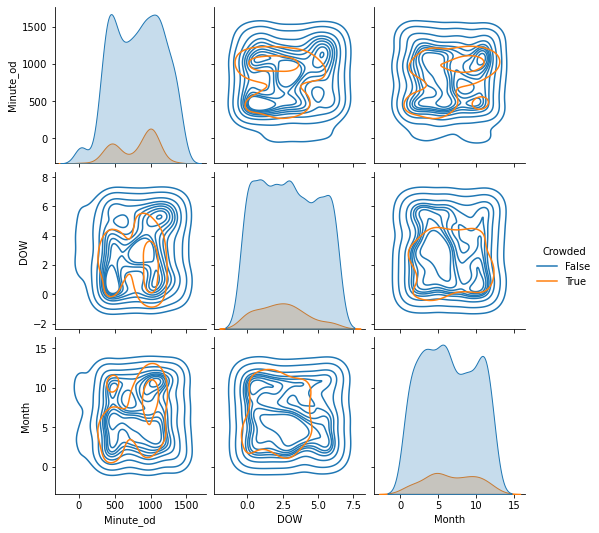

In [61]:
sns.pairplot(df, vars=['Minute_od','DOW','Month'], kind='kde', hue='Crowded')

Looking at Minute_od, DOW, and Month as continuous values is fundamentally weird.

Try looking at these as categorical variables.

#### Below plot needs help... try doing a separate True plot and separaate false plot

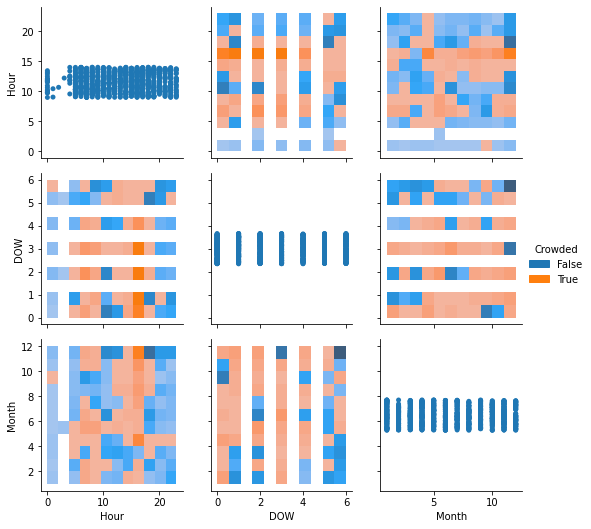

In [69]:
g = sns.PairGrid(df, vars=['Hour','DOW','Month'], hue='Crowded')
g.map_diag(sns.stripplot)
g.map_offdiag(sns.histplot)
g.add_legend()

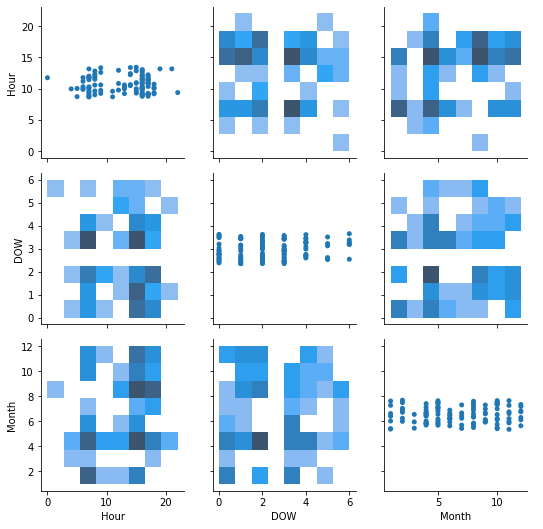

In [74]:
g = sns.PairGrid(df[df['Crowded']], vars=['Hour','DOW','Month'])
g.map_diag(sns.stripplot)
g.map_offdiag(sns.histplot)
g.add_legend()

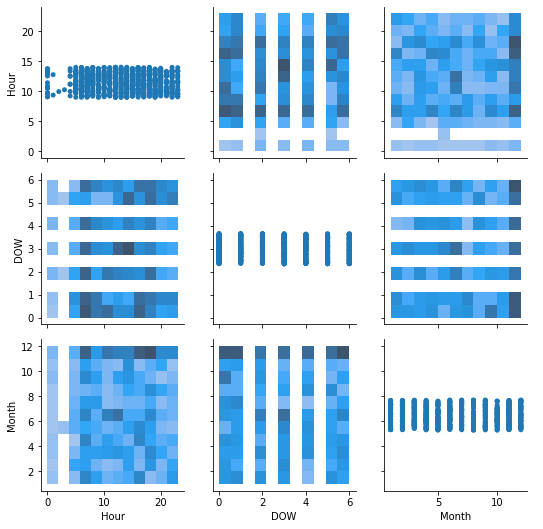

In [75]:
g = sns.PairGrid(df[~df['Crowded']], vars=['Hour','DOW','Month'])
g.map_diag(sns.stripplot)
g.map_offdiag(sns.histplot)
g.add_legend()

The above didn't really work well. I think the sample is too small, and there aren't any good visualization techniques for 2 categorical variables.

Idea: make 3 different heatmaps.

Idea: try every combo of Hour, DOW, and Month (2016 combos) and see which combos have the highest proportion of Crowded

In [87]:
df02.groupby(['Hour','DOW','Month'])['Crowded'].mean().sort_values().tail(20)

Hour  DOW  Month
17    1    3        0.333982
16    3    10       0.336227
      4    10       0.339029
17    1    8        0.341241
      2    5        0.346047
16    3    8        0.346373
2     2    6        0.357143
17    2    8        0.358491
      3    10       0.362261
           8        0.363086
3     0    4        0.368421
5     6    2        0.368821
2     1    6        0.371429
17    2    7        0.375661
           10       0.388048
2     0    9        0.400000
3     0    10       0.529412
      3    6        0.562500
2     1    10       0.625000
4     6    11       1.000000
Name: Crowded, dtype: float64

Upshot: Even in these times when Crowded is *most* separable from NonCrowded, it's still not really separable. For all but 4 combos out of around 2000 combos, the chances are still that the observation more likely NonCrowded.

So, we need more information than just Hour, DOW, and Month to make any kind of useful classifier.

Just to completely prove this, let's do a logistic regression where we use Hour, DOW and Month as factors.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()

In [97]:
# doesn't even take into account station
feats02 = ['Hour','DOW','Month']

In [88]:
df = df02
feats = feats01

In [89]:
X = df.loc[:,feats]

y = df.loc[:,'Crowded'].astype(int)

X, y = shuffle(X, y, random_state=19)

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=19)

In [91]:
from sklearn.preprocessing import OneHotEncoder

In [92]:
enc = OneHotEncoder()
X_train_b = enc.fit_transform(X_train)

In [95]:
logi02 = LogisticRegression(class_weight='balanced', solver='sag')
scores = cv_readout(logi02,
                    X_train_b,
                    y_train)
scores

Performing 5-fold cross-validation...


C:\Users\augus\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Starting work on a new fold...


C:\Users\augus\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Starting work on a new fold...


C:\Users\augus\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Starting work on a new fold...


C:\Users\augus\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Starting work on a new fold...


C:\Users\augus\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Starting work on a new fold...
Aggregating the scores...
[[607546 327355]
 [ 29705  71411]]
               mean       std
precision  0.179145   0.00231
recall     0.706229   0.01505
f1         0.285747  0.002199


In [96]:
logi03 = LogisticRegression(class_weight='balanced', solver='saga')
scores = cv_readout(logi03,
                    X_train_b,
                    y_train)
scores

Performing 5-fold cross-validation...
Starting work on a new fold...


C:\Users\augus\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Starting work on a new fold...


C:\Users\augus\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Starting work on a new fold...
Starting work on a new fold...


C:\Users\augus\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Starting work on a new fold...
Aggregating the scores...
[[601363 333538]
 [ 28834  72282]]
               mean       std
precision  0.178112  0.000343
recall     0.714842  0.004356
f1          0.28517  0.000755


Oops, I accidentally used minutes of the day as separate categories instead of hours. Try again below.

In [98]:
df = df02
feats = feats02

In [99]:
X = df.loc[:,feats]

y = df.loc[:,'Crowded'].astype(int)

X, y = shuffle(X, y, random_state=19)

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=19)

In [101]:
from sklearn.preprocessing import OneHotEncoder

In [102]:
enc = OneHotEncoder()
X_train_b = enc.fit_transform(X_train)

In [105]:
X_train_b

<1036017x43 sparse matrix of type '<class 'numpy.float64'>'
	with 3108051 stored elements in Compressed Sparse Row format>

In [106]:
logi04 = LogisticRegression(class_weight='balanced', solver='sag')
scores = cv_readout(logi04,
                    X_train_b,
                    y_train)
scores

Performing 5-fold cross-validation...


C:\Users\augus\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Starting work on a new fold...


C:\Users\augus\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Starting work on a new fold...


C:\Users\augus\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Starting work on a new fold...


C:\Users\augus\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Starting work on a new fold...


C:\Users\augus\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Starting work on a new fold...
Aggregating the scores...
[[598832 336069]
 [ 29429  71687]]
               mean       std
precision   0.17581  0.001235
recall     0.708958    0.0077
f1         0.281747  0.001976


In [107]:
logi05 = LogisticRegression(class_weight='balanced', solver='saga')
scores = cv_readout(logi05,
                    X_train_b,
                    y_train)
scores

Performing 5-fold cross-validation...


C:\Users\augus\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Starting work on a new fold...


C:\Users\augus\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Starting work on a new fold...


C:\Users\augus\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Starting work on a new fold...
Starting work on a new fold...
Starting work on a new fold...
Aggregating the scores...
[[599360 335541]
 [ 29341  71775]]
               mean       std
precision  0.176213  0.000774
recall     0.709828  0.005822
f1         0.282336  0.001366


The best model so far was one with Minute! Interesting. I think that is because Minute secretly encodes which Station it was at.

I bet Hour combined with Station will be better.

What happens when we add in station?

In [110]:
# doesn't even take into account station
feats03 = ['Hour','DOW','Month','station name']

df = df02
feats = feats03

X = df.loc[:,feats]
y = df.loc[:,'Crowded'].astype(int)
X, y = shuffle(X, y, random_state=19)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=19)

In [111]:
enc = OneHotEncoder()
X_train_b = enc.fit_transform(X_train)

In [112]:
logi07 = LogisticRegression(class_weight='balanced', solver='sag')
scores = cv_readout(logi07,
                    X_train_b,
                    y_train)
scores

Performing 5-fold cross-validation...


C:\Users\augus\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Starting work on a new fold...


C:\Users\augus\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Starting work on a new fold...


C:\Users\augus\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Starting work on a new fold...


C:\Users\augus\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Starting work on a new fold...
Starting work on a new fold...
Aggregating the scores...
[[684412 250489]
 [ 28592  72524]]
               mean       std
precision     0.225  0.008726
recall     0.717235  0.041449
f1         0.342146    0.0101


C:\Users\augus\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [113]:
logi08 = LogisticRegression(class_weight='balanced', solver='saga')
scores = cv_readout(logi08,
                    X_train_b,
                    y_train)
scores

Performing 5-fold cross-validation...


C:\Users\augus\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Starting work on a new fold...


C:\Users\augus\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Starting work on a new fold...


C:\Users\augus\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Starting work on a new fold...


C:\Users\augus\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Starting work on a new fold...


C:\Users\augus\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Starting work on a new fold...
Aggregating the scores...
[[652473 282428]
 [ 20016  81100]]
               mean       std
precision  0.223092  0.000393
recall     0.802049  0.002782
f1         0.349084   0.00053


In [114]:
logi09 = LogisticRegression(class_weight='balanced', solver='saga', max_iter=200)
scores = cv_readout(logi09,
                    X_train_b,
                    y_train)
scores

Performing 5-fold cross-validation...


C:\Users\augus\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Starting work on a new fold...


C:\Users\augus\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Starting work on a new fold...


C:\Users\augus\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Starting work on a new fold...


C:\Users\augus\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Starting work on a new fold...


C:\Users\augus\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Starting work on a new fold...
Aggregating the scores...
[[652473 282428]
 [ 20016  81100]]
               mean       std
precision  0.223092  0.000393
recall     0.802049  0.002782
f1         0.349084   0.00053


## Check how passwithin is calculated 7/24

Result was that I compiled a CSV of routes where passwithin was calculated incorrectly.

In [130]:
df = data2019
trips = df['routedone'].unique()
matches = []
mismatches = []

for trip in trips:
    tripdf = df[df['routedone']==trip]
    tripdf = tripdf.sort_values('stop arrival time').reset_index(drop=True)
    
    for i in range(1,len(tripdf)):
        calc = tripdf.at[i-1,'passwithin'] + tripdf.at[i,'passboarding'] - tripdf.at[i,'passexiting']
        if tripdf.at[i,'passwithin'] == calc:
            matches.append((trip, i))
        if tripdf.at[i,'passwithin'] != calc:
            mismatches.append((trip,i))
    
print(len(mismatches))

2553


In [124]:
len(df) - len(trips)

1232629

We have 2553 mismatches out of a possible 1232629. That's about 0.2%. But... what is going on with those few mismatches?

Some mismatches are just one mismatch in a larger trip. Some are a mismatch for every observation in the trip.

In [145]:
mismatches[180:190]

[(31351969, 3),
 (31351969, 4),
 (31351969, 5),
 (31351969, 6),
 (31351969, 7),
 (31351969, 8),
 (31351969, 9),
 (31351969, 11),
 (31351969, 12),
 (31351969, 13)]

In [162]:
tripdf = df[df['routedone']==31351969]
tripdf = tripdf.sort_values('stop arrival time').reset_index(drop=True)

tripdf

railcar ID  passboarding  passexiting  passwithin  routedone  \
0          109             5            0           0   31351969   
1          109             2            0           0   31351969   
2          109             0            0           0   31351969   
3          109             0            1           0   31351969   
4          109             6            0           0   31351969   
5          109             6            1           0   31351969   
6          109             3            2           0   31351969   
7          109             0            1           0   31351969   
8          109             7            2           0   31351969   
9          109             1            0           0   31351969   
10         109             4            4           0   31351969   
11         109             2            1           0   31351969   
12         109             0            3           0   31351969   
13         109            12            5           0   31351969   
14         109             0           17           0   31351969   
15         109             0           12           0   31351969   

     route finish time    route start time   stop arrival time   station name  \
0  2019-01-12 16:58:08 2019-01-12 16:00:14 2019-01-12 16:00:14          Angle   
1  2019-01-12 16:58:08 2019-01-12 16:00:14 2019-01-12 16:02:50         SeaTac   
2  2019-01-12 16:58:08 2019-01-12 16:00:14 2019-01-12 16:05:55        Tukwila   
3  2019-01-12 16:58:08 2019-01-12 16:00:14 2019-01-12 16:14:37        Rainier   
4  2019-01-12 16:58:08 2019-01-12 16:00:14 2019-01-12 16:17:36        Othello   
5  2019-01-12 16:58:08 2019-01-12 16:00:14 2019-01-12 16:21:22       Columbia   
6  2019-01-12 16:58:08 2019-01-12 16:00:14 2019-01-12 16:24:18          Baker   
7  2019-01-12 16:58:08 2019-01-12 16:00:14 2019-01-12 16:26:28         Beacon   
8  2019-01-12 16:58:08 2019-01-12 16:00:14 2019-01-12 16:29:21           SODO   
9  2019-01-12 16:58:08 2019-01-12 16:00:14 2019-01-12 16:31:44        Stadium   
10 2019-01-12 16:58:08 2019-01-12 16:00:14 2019-01-12 16:35:17  Intl District   
11 2019-01-12 16:58:08 2019-01-12 16:00:14 2019-01-12 16:36:46        Pioneer   
12 2019-01-12 16:58:08 2019-01-12 16:00:14 2019-01-12 16:38:35     University   
13 2019-01-12 16:58:08 2019-01-12 16:00:14 2019-01-12 16:41:27       Westlake   
14 2019-01-12 16:58:08 2019-01-12 16:00:14 2019-01-12 16:44:13  Capitol Hill    
15 2019-01-12 16:58:08 2019-01-12 16:00:14 2019-01-12 16:58:08            UW    

     next station  ...  Crowded240       TOD  DOW  DOW_name        Date  Hour  \
0          SeaTac  ...       False  16:00:14    5  Saturday  2019-01-12    16   
1         Tukwila  ...       False  16:02:50    5  Saturday  2019-01-12    16   
2         Rainier  ...       False  16:05:55    5  Saturday  2019-01-12    16   
3         Othello  ...       False  16:14:37    5  Saturday  2019-01-12    16   
4        Columbia  ...       False  16:17:36    5  Saturday  2019-01-12    16   
5           Baker  ...       False  16:21:22    5  Saturday  2019-01-12    16   
6          Beacon  ...       False  16:24:18    5  Saturday  2019-01-12    16   
7            SODO  ...       False  16:26:28    5  Saturday  2019-01-12    16   
8         Stadium  ...       False  16:29:21    5  Saturday  2019-01-12    16   
9   Intl District  ...       False  16:31:44    5  Saturday  2019-01-12    16   
10        Pioneer  ...       False  16:35:17    5  Saturday  2019-01-12    16   
11     University  ...       False  16:36:46    5  Saturday  2019-01-12    16   
12       Westlake  ...       False  16:38:35    5  Saturday  2019-01-12    16   
13  Capitol Hill   ...       False  16:41:27    5  Saturday  2019-01-12    16   
14            UW   ...       False  16:44:13    5  Saturday  2019-01-12    16   
15            UW   ...       False  16:58:08    5  Saturday  2019-01-12    16   

    Minute  Minute_od  Month  Month_name  
0        0        960      1     January  
1    

Looking at the 0.2% of observations where the calculation did not hold true, there were various causes. For some of these the counter was reset but the routedone didn't increment. In some cases that made sense because there was a couple-hours gap in service, so I assume there was maintenance being done. In other cases such a reset didn't make sense, because there was no gap in service and the equation shows that, say, -20 people are within, because it ignores how many were within at the previous stop. Finally, in some routes, passwithin​ stayed at 0 the whole time even though there were reasonable values for passboarding​ and passexiting​.

I'm removing all the routedone​s that have any of those errors. This way, I know that my entire dataset accords with the equation (passwithin​ equals previous stop's passwithin​ plus the current stop's passboarding​ minus the current stop's passexiting). 


In [167]:
mismatches[50:60]

[(31251428, 4),
 (31251428, 5),
 (31251428, 6),
 (31251428, 7),
 (31251428, 8),
 (31251428, 9),
 (31251428, 11),
 (31251428, 12),
 (31251428, 13),
 (31251428, 14)]

In [171]:
routes_against_calc = [p[0] for p in mismatches]
routes_against_calc = np.unique(routes_against_calc)

In [159]:
pd.DataFrame(routes_against_calc).to_csv('routes_against_calc.csv', index=False)

In [170]:
sum([p == 31351969 for p in routes_against_calc])

1

In [164]:
len(routes_against_calc)

1504

## 7/26 Create list of routes with abnormal stadir

In [175]:
df = data2019

# Create a station ID
# Use a dictionary
names = ['Zero','Angle','SeaTac','Tukwila','Rainier','Othello',
         'Columbia','Baker','Beacon','SODO','Stadium','Intl District',
         'Pioneer','University','Westlake','Capitol Hill ','UW ']

for idx, name in enumerate(names):
    df.loc[df['station name']==name, 'sta_ID'] = idx
    df.loc[df['next station']==name, 'nxsta_ID'] = idx
    
df['sta_ID'] = df['sta_ID'].astype('int32')
df['nxsta_ID'] = df['nxsta_ID'].astype('int32')
df['stadir_ID'] = df['sta_ID'] * 100 + df['nxsta_ID']

In [188]:
# How many stadir_ID are there?

len(df.groupby('stadir_ID').count().iloc[:,0])

232

In [189]:
# W are the normal stadir?
counts = df.groupby('stadir_ID').count().iloc[:,0]
normal_stadir = list(counts[counts > 10000].index)

In [190]:
# Create df with only abnormal stops
abnormal_stops = df[~df['stadir_ID'].isin(normal_stadir)]

# Create list of abnormal routes
# abnormal routes are routes in which there is at least one abnormal stop
abnormal_routes = abnormal_stops['routedone'].unique()

len(abnormal_routes)

8306

In [191]:
pd.DataFrame(abnormal_routes).to_csv('abnormal_stadir_routes.csv', index=False)

In [160]:
foo = pd.read_csv('routes_against_calc.csv')

In [161]:
foo

0
0     31198589
1     31198638
2     31198663
3     31198725
4     31198746
...        ...
1499  36371158
1500  36371429
1501  36380509
1502  36407734
1503  36408661

[1504 rows x 1 columns]

In [174]:
sum([p == 31351969 for p in foo.iloc[:,0]])

1

*Is there a "soft classification" technique? I.e. something where we want to classify over 74 versus under 74, but we penalize farther away errors more?

** that might be a regression problem with an interesting error function

### Word bank

In [102]:
# supervised machine learning
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
import statsmodels.api as sm
import warnings 
#warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.svm import SVR